### LASSO parameter range experiments, single gene

`scikit-learn` has two different implementations of logistic regression: [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) (using the `liblinear` coordinate descent optimizer) and [SGDClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html) (using stochastic gradient descent for optimization).

In this script we want to compare their performance and model selection dynamics across different levels of regularization, in depth for a single gene in our cancer gene set.

In [1]:
import os
import itertools as it

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from scipy.stats import pearsonr
import seaborn as sns

import pancancer_evaluation.config as cfg
import pancancer_evaluation.utilities.data_utilities as du
import pancancer_evaluation.utilities.analysis_utilities as au

%load_ext autoreload
%autoreload 2

In [2]:
results_dirs = {
    'optimal': (
        os.path.join(cfg.repo_root, '01_stratified_classification', 'results', 'optimizer_compare_sgd_lr_optimal_range', 'gene')
    ),
    'adaptive': (
        os.path.join(cfg.repo_root, '01_stratified_classification', 'results', 'optimizer_compare_sgd_lr_adaptive_range', 'gene')
    ),
    'constant': (
        os.path.join(cfg.repo_root, '01_stratified_classification', 'results', 'optimizer_compare_sgd_lr_constant_range', 'gene')
    ),
    'constant_search': (
        os.path.join(cfg.repo_root, '01_stratified_classification', 'results', 'optimizer_compare_sgd_lr_constant_search', 'gene')
    ),
    # 'invscaling': (
    #     os.path.join(cfg.repo_root, '01_stratified_classification', 'results', 'optimizer_compare_sgd_lr_invscaling', 'gene')
    # )
}
lr_schedules = list(results_dirs.keys())

ll_results_dir = os.path.join(
    cfg.repo_root, '01_stratified_classification', 'results', 'optimizer_compare_ll', 'gene'
)

plot_gene = 'KRAS'
metric = 'aupr'

output_plots = True
output_plots_dir = os.path.join(
    cfg.repo_root, '01_stratified_classification', 'optimizers_plots'
)

### Get performance information for each lasso penalty

In [3]:
all_perf_df = []

for lr_schedule in lr_schedules:
    perf_df = au.load_prediction_results_lasso_range(
        results_dirs[lr_schedule],
        'stratified',
        gene=plot_gene
    )
    perf_df = (
        perf_df[perf_df.gene == plot_gene]
        .drop(columns=['holdout_cancer_type', 'experiment'])
        .copy()
    )
    perf_df['lr_schedule'] = lr_schedule
    all_perf_df.append(perf_df)
    
all_perf_df = pd.concat(all_perf_df)
print(all_perf_df.lr_schedule.unique())
print(all_perf_df.shape)
all_perf_df.head()

['optimal' 'adaptive' 'constant' 'constant_search']
(1296, 9)


,auroc,aupr,gene,signal,seed,data_type,fold,lasso_param,lr_schedule
0,1.00000,1.00000,KRAS,signal,42,train,0,1e-06,optimal
1,0.81240,0.59816,KRAS,signal,42,test,0,1e-06,optimal
2,0.80824,0.61677,KRAS,signal,42,cv,0,1e-06,optimal
3,1.00000,1.00000,KRAS,signal,42,train,1,1e-06,optimal
4,0.81665,0.62870,KRAS,signal,42,test,1,1e-06,optimal


In [4]:
# load liblinear data to use as a baseline
ll_perf_df = au.load_prediction_results_lasso_range(ll_results_dir,
                                                    'stratified',
                                                    gene=plot_gene)
ll_perf_df = (
    ll_perf_df[ll_perf_df.gene == plot_gene]
    .drop(columns=['holdout_cancer_type', 'experiment'])
    .copy()
)

# get mean performance for each lasso parameter
ll_mean_perf_df = (
    ll_perf_df[ll_perf_df.data_type == 'test']
      .drop(columns=['gene', 'signal', 'data_type'])
      .groupby('lasso_param')
      .agg([np.mean, np.std])
).loc[:, 'aupr']
 
ll_mean_perf_df.head()

,mean,std
lasso_param,,
0.001,0.244528,0.014684
0.005,0.470004,0.049469
0.01,0.607011,0.050356
0.05,0.699485,0.056470
0.1,0.691666,0.056338


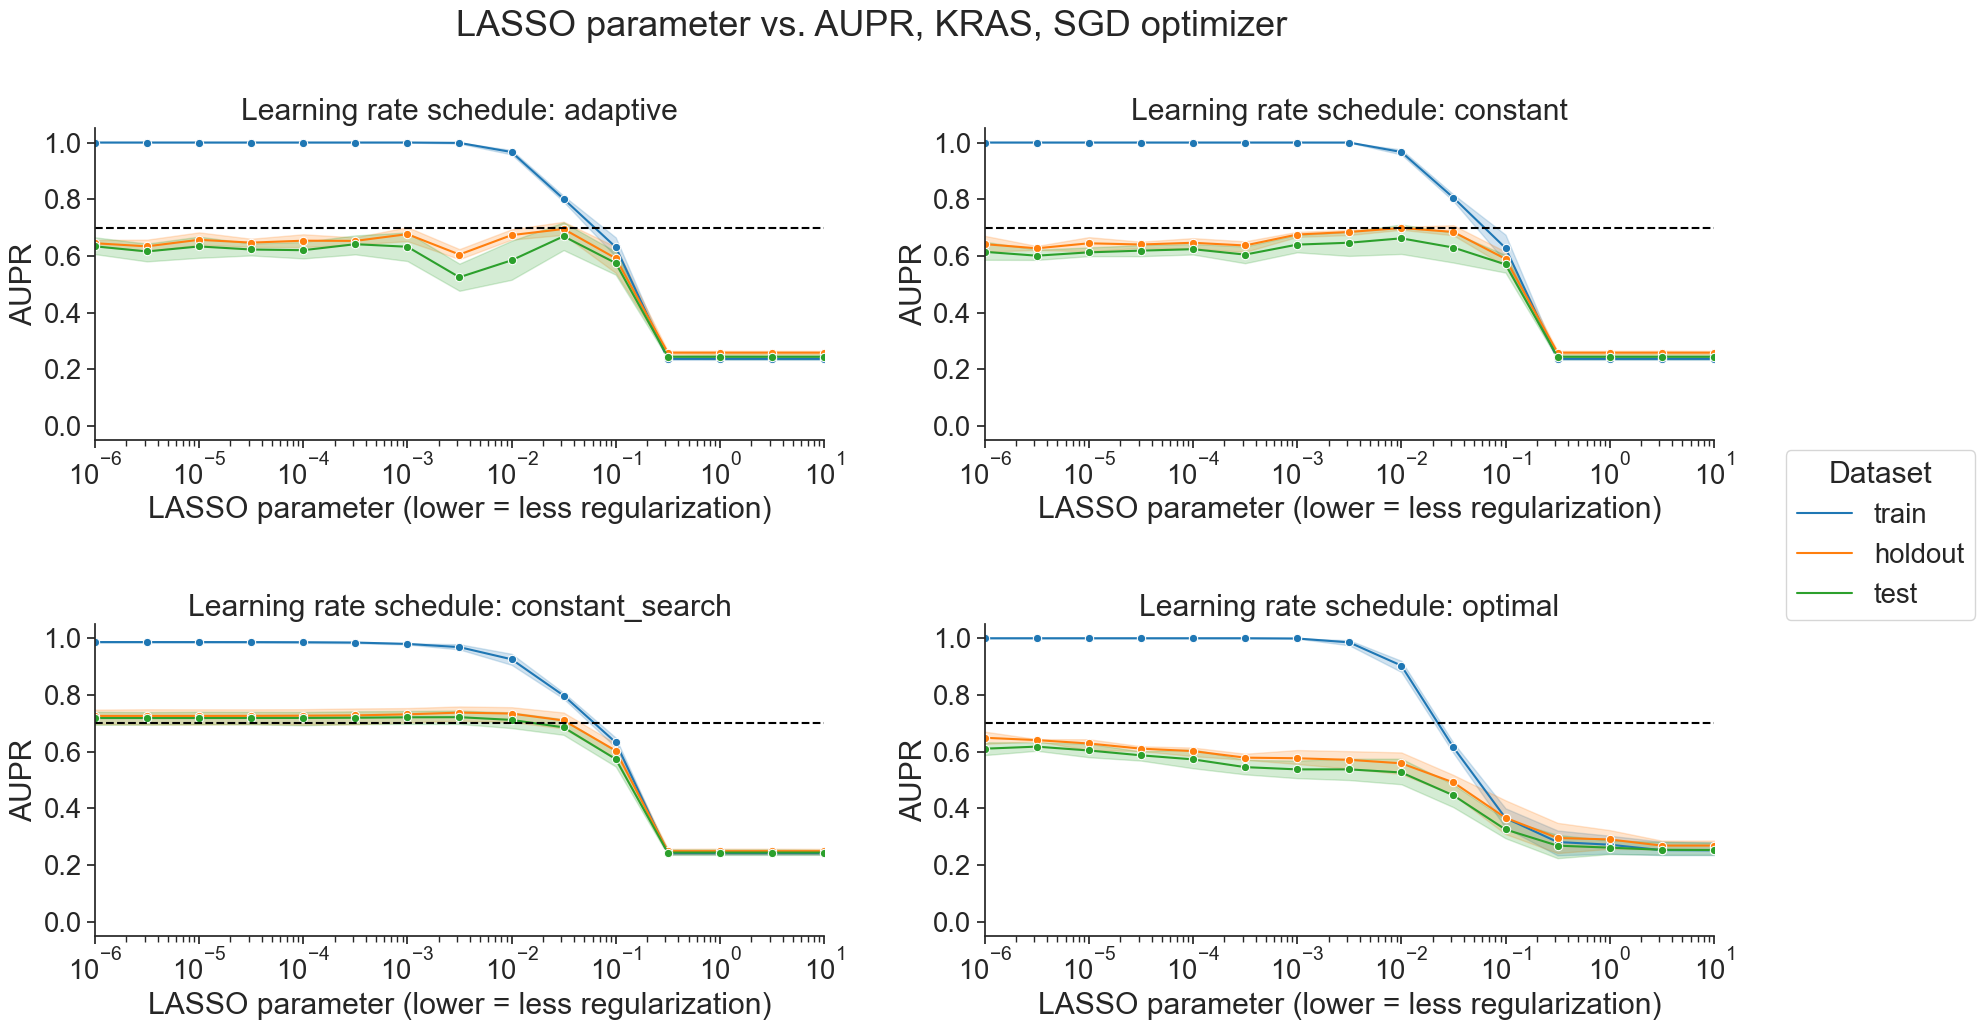

In [5]:
sns.set_style('ticks')

plot_df = (
    all_perf_df[(all_perf_df.signal == 'signal')]
      .sort_values(by=['lr_schedule', 'lasso_param'])
      .reset_index(drop=True)
)
plot_df.lasso_param = plot_df.lasso_param.astype(float)

with sns.plotting_context('notebook', font_scale=1.8):
    g = sns.relplot(
        data=plot_df,
        x='lasso_param', y=metric, hue='data_type',
        hue_order=['train', 'cv', 'test'],
        marker='o', kind='line', col='lr_schedule',
        col_wrap=2, height=5, aspect=1.6,
        facet_kws={'sharex': False, 'sharey': False}
    )
    for i, ax in enumerate(g.axes):
        ax.axhline(ll_mean_perf_df['mean'].max(), linestyle='--', color='black')
    g.set(xscale='log', xlim=(10e-7, 10), ylim=(-0.05, 1.05))
    # set labels individually, by default seaborn set_xlabels/set_ylabels hide inner ones
    for ax in g.axes.flat:
        ax.set_xlabel('LASSO parameter (lower = less regularization)', visible=True)
        ax.set_ylabel(f'{metric.upper()}', visible=True)
    sns.move_legend(g, "center", bbox_to_anchor=[1.075, 0.5], frameon=True)
    g._legend.set_title('Dataset')
    new_labels = ['train', 'holdout', 'test']
    for t, l in zip(g._legend.texts, new_labels):
        t.set_text(l)
    g.set_titles('Learning rate schedule: {col_name}')
     
    plt.suptitle(f'LASSO parameter vs. {metric.upper()}, {plot_gene}, SGD optimizer', y=1.025)

plt.tight_layout(w_pad=4, h_pad=5)

if output_plots:
    os.makedirs(output_plots_dir, exist_ok=True)
    plt.savefig(os.path.join(output_plots_dir, f'{plot_gene}_learning_rate_schedule_compare.svg'), bbox_inches='tight')

### Get nonzero coefficient info, and bin models by nonzero coefficients

We'll try doing this both linearly (just 10 evenly spaced bins) and based on the deciles of the nonzero coefficient distributions.

In [6]:
all_coefs_df = []

for lr_schedule in lr_schedules:
    for coef_info in au.generate_nonzero_coefficients_lasso_range(results_dirs[lr_schedule],
                                                                  gene=plot_gene,
                                                                  nonzero_only=False):
        (gene,
         cancer_type,
         seed,
         lasso_param,
         coefs_list) = coef_info
        for fold_no, coefs in enumerate(coefs_list):
            all_coefs_df.append([lr_schedule, seed, fold_no, lasso_param,
                                 np.sum(np.absolute(list(zip(*coefs))[1]))+1])
    
all_coefs_df = pd.DataFrame(
    all_coefs_df,
    columns=['lr_schedule', 'seed', 'fold', 'lasso_param', 'sum_coefs']
)
all_coefs_df.lasso_param = all_coefs_df.lasso_param.astype(float)
all_coefs_df.sort_values(by='lasso_param')

print(all_coefs_df.lr_schedule.unique())
print(all_coefs_df.shape)
all_coefs_df.head()

['optimal' 'adaptive' 'constant' 'constant_search']
(432, 5)


,lr_schedule,seed,fold,lasso_param,sum_coefs
0,optimal,42,0,0.000316,6.578888e+05
1,optimal,42,1,0.000316,5.272115e+05
2,optimal,42,2,0.000316,6.163456e+05
3,optimal,42,3,0.000316,6.427547e+05
4,optimal,42,0,0.000032,2.320549e+06


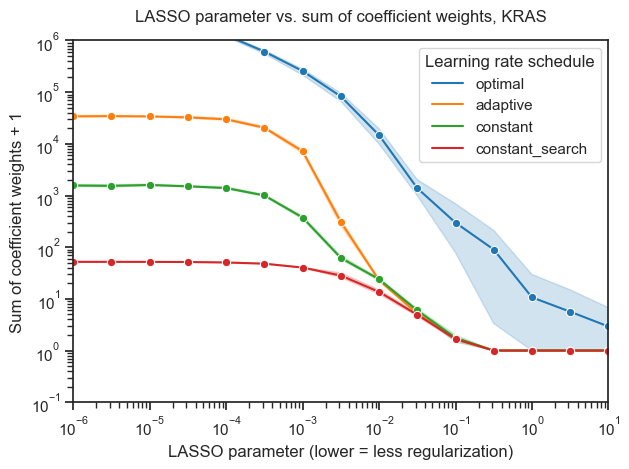

In [7]:
sns.set_style('ticks')

with sns.plotting_context('notebook', font_scale=1.0):
    g = sns.lineplot(
        data=all_coefs_df,
        x='lasso_param', y='sum_coefs', hue='lr_schedule',
        hue_order=lr_schedules, marker='o',
    )
    g.set(xscale='log', yscale='log', xlim=(10e-7, 10), ylim=(10e-2, 10e5))
    g.set_xlabel('LASSO parameter (lower = less regularization)')
    g.set_ylabel('Sum of coefficient weights + 1')
    plt.legend(title='Learning rate schedule')
    plt.title(f'LASSO parameter vs. sum of coefficient weights, {plot_gene}', y=1.03)

plt.tight_layout()

if output_plots:
    plt.savefig(os.path.join(output_plots_dir, f'{plot_gene}_learning_rate_schedule_coefs.svg'), bbox_inches='tight')